# Supporting Analyses
A quick explanation of some straightforward supplemental analyses that provide useful statistics for explaining some of the smaller details of our data. 

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import signal as sig
idx = pd.IndexSlice

ROOT = os.environ['HOME'] + '/python/'

## Switch Trial
This metric will calculate the number of trials after a reversal happens it takes for the probability of choosing the newly rewarded goal crosses the 0.5 line. That is, how many trials before it is likelier for an animal to switch responding

In [2]:
def calculate_switch_trials(DSR, window_size = 7):
    ST = []
    for rat_label, rat in DSR.groupby('rat'):
        for treatment_label, treatment in rat.groupby('Infusion_String'):
            learningCurve = []
            noTrials = len(treatment)
            for trial in range(noTrials):
                b_index = int(max(0, trial - np.floor(window_size/2)))
                t_index = int(min(noTrials, trial + np.ceil(np.float(window_size)/2)))

                mov_avg = np.float(np.sum(
                            treatment['Choice'].iloc[b_index:t_index])) / window_size
                learningCurve.append(mov_avg)
            smooth_signal = sig.savgol_filter(learningCurve, window_size, 2)
            treatment['smooth'] = smooth_signal
            Rev1 = treatment.loc[idx[:,:,2,:],:]
            if len(Rev1) > 10:
                if Rev1['GA'].iloc[0]:
                    switch_trial = 1 + \
                            np.min(np.nonzero((Rev1['smooth'].values > 0.5).ravel())[0])
                else:
                    switch_trial = 1 + \
                            np.min(np.nonzero((Rev1['smooth'].values < 0.5).ravel())[0])
                ST.append(switch_trial)
    return ST

## Timing Curve
Calculates the average time it takes to complete a trial per block for each dataset. This analysis came as we surprisingly found that the time it takes to do the first block is considerably longer than subsequent blocks. It seems animals "warm up" too.

In [18]:
def plot_timing_curve(path = ROOT + 'behavioral_performance/data/dataset_dataframes/Saline_DSR.p'):
    DSR = pickle.load(open(path,'rb'))
    blocks = {}
    for rat_label, rat in DSR.groupby('rat'):
        for treatment_label, treatment in rat.groupby('Infusion_String'):
            for block_label, block in treatment.groupby('block'):
                if block_label not in blocks.keys():
                    blocks[block_label] = []
                blocks[block_label].append(np.nanmean(np.sum( \
                                block.loc[:,['t3','t4']], axis = 1)))

    time_means = [np.nanmean(w) for key, w in blocks.iteritems()]
    time_sem = [np.std(w) / np.sqrt(len(w)) for key, w in blocks.iteritems()]


    plt.errorbar(blocks.keys(), time_means, yerr = time_sem)
    plt.xticks(blocks.keys())
    plt.title('Timing Per Block - PSR')
    plt.ylabel('Time to complete trial (seconds)')
    plt.xlabel('Block')
    plt.savefig(ROOT + 'Results/TimingBlocksPSR.jpg', dpi=400)
    plt.show()
    return time_means, time_sem


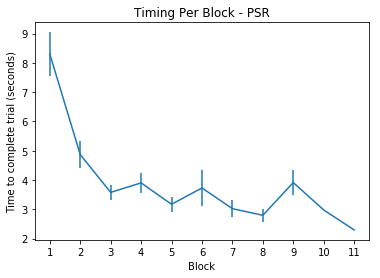

[0.74, 0.45, 0.26, 0.33, 0.25, 0.62, 0.3, 0.22, 0.44, 0.0, 0.0]


In [20]:
mu, sem = plot_timing_curve()
print [np.float('%1.2f' %w) for w in sem]

## Win-Stay and Lose-Shift Analysis
This is a quick calculation of the probaility of an animal of win-staying (repeating a choice if it was rewarded) vs lose-shifting (switching responding after a non-reward choice). 

In [4]:
def WS_LS(path = ROOT + 'behavioral_performance/data/dataset_dataframes/Saline_PSR.p' ):
    DSR = pickle.load(open(path, 'rb'))
    WS = []
    LS = []
    for rat_label, rat in DSR.groupby('rat'):
        for treatment_label, treatment in rat.groupby('Infusion_String'):
            wstay, wshift, lstay, lshift = 0,0,0,0
            for trial in range(1, len(treatment)):
                if treatment['Choice'].iloc[trial] \
                == treatment['Choice'].iloc[trial - 1]:
                    stay = 1
                else:
                    stay = 0
                if treatment['AR'].iloc[trial - 1] == 1:
                    win = 1
                else:
                    win = 0

                if stay == 1 and win == 1:
                    wstay += 1
                elif stay == 1 and win == 0:
                    lstay += 1
                elif stay == 0 and win == 1:
                    wshift += 1
                elif stay == 0 and win == 0:
                    lshift += 1
            WS.append(np.float(wstay) / (wstay + wshift))
            LS.append(np.float(lshift) / (lstay + lshift))
    return WS, LS
